In [5]:
from models import *
from DScontrol import *
import matplotlib.pyplot as plt
import warnings
from skimage.transform import rotate, resize, hough_line, hough_line_peaks
from skimage.feature import canny

In [6]:
edge = EdgeBlur(15, 5, 15, 1, 5)
gabor = FourierGabor(5, 5, 5)

predict = {
    #'EdgeBlur':[],
    #'EdgeBlur_error':[],
    'FourierGabor':[],
    'FourierGabor_error':[]
}
total = len(DS)
for i, filename in enumerate(DS.filename):
    image = get(filename)
    
    '''with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        area, error = edge.predict(image)
        predict['EdgeBlur'].append(area)
        predict['EdgeBlur_error'].append(error)
    area, error = gabor.predict(image)
    predict['FourierGabor'].append(area)
    predict['FourierGabor_error'].append(error)'''
    
    img = rgb2gray(image)
    
    _, angles, _ = hough_line_peaks(*hough_line(canny(img), np.linspace(-np.pi/2, np.pi/2, 500)))
    slopes = np.degrees(angles + np.pi/2)
    slope_values = np.unique(slopes)
    probs = np.array([np.sum(slopes == val)/len(slopes) for val in slope_values])
    img_slope = slope_values[probs == probs.max()][0]
    img = rotate(img, img_slope, mode='reflect')
    
    Fx = np.apply_along_axis(pixel_scale_1d, 0, image)
    Fy = np.apply_along_axis(pixel_scale_1d, 1, image)
    fx, fy = np.median(Fx[Fx > 0.025]), np.median(Fy[Fy > 0.025])
    filtered = power(img, gabor_kernel(fx, theta=0)) + power(img, gabor_kernel(fy, theta=np.pi/2))
    mask = filtered < threshold_minimum(filtered)
    mask = nd.binary_opening(mask, iterations=14)
    mask = nd.binary_closing(mask, iterations=10)
    mask = nd.binary_dilation(mask, iterations=5)
    #mask = rotate(mask, -img_slope)
    
    predict['FourierGabor'].append(np.sum(mask)*fx*fy)

    print(f'{i+1}/{total}|{(i/total*100):.2f}%', end='\r')

In [40]:
ds = pd.concat([DS, pd.DataFrame(predict)], axis=1)
ds

,filename,area,FourierGabor,FourierGabor_error
0,0.jpg,100.473,105.027969,0.227643
1,1.jpg,127.880,135.908127,0.023820
2,2.jpg,161.820,171.705444,0.062668
3,3.jpg,190.003,181.720215,0.463668
4,4.jpg,22.713,21.627853,0.009092
...,...,...,...,...
350,350.jpg,98.599,100.750671,0.056719
351,351.jpg,98.599,100.099060,0.122426
352,352.jpg,98.599,100.805054,0.090786
353,353.jpg,98.599,100.429565,0.113918


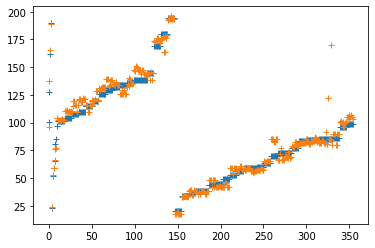

In [8]:
plt.plot(DS.area, '+')
plt.plot(predict['FourierGabor'], '+')
#plt.plot(ds.EdgeBlur, '+')
plt.show()

In [33]:
ds['disp'] = ds.area - ds.FourierGabor

In [34]:
(np.abs(ds.disp)/ds.area*100).describe()

count    355.000000
mean      20.458294
std       56.856990
min        0.000822
25%        4.856307
50%       11.498254
75%       16.079480
max      397.087664
dtype: float64

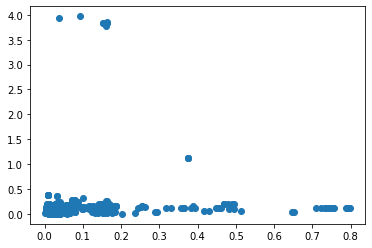

In [38]:
plt.plot(ds.FourierGabor_error, np.abs(ds.disp)/ds.area, 'o')